In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create checkpoint directory di Drive
import os
os.makedirs('/content/drive/MyDrive/deepfake_checkpoints', exist_ok=True)

print(" Google Drive mounted!")
print(" Checkpoint dir: /content/drive/MyDrive/deepfake_checkpoints")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted!
📁 Checkpoint dir: /content/drive/MyDrive/deepfake_checkpoints


In [ ]:
import kagglehub

# Download preprocessed dataset
path = kagglehub.dataset_download("mbulsss/fakeavceleb-preprocessed-frame")
print(f"\n Dataset path: {path}")
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import timm
from datetime import datetime
import json
import matplotlib.pyplot as plt

print("="*70)
print("SYSTEM INFO")
print("="*70)
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print("="*70)


Using Colab cache for faster access to the 'fakeavceleb-preprocessed-frame' dataset.

📁 Dataset path: /kaggle/input/fakeavceleb-preprocessed-frame
🔧 SYSTEM INFO
PyTorch: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB


In [9]:
# Configuration
class Config:
    # Paths
    DATA_ROOT = path
    TRAIN_CSV = "train_frames_kaggle.csv"
    VAL_CSV   = "val_frames_kaggle.csv"
    TEST_CSV  = "test_frames_kaggle.csv"

    # Google Drive checkpoint path
    DRIVE_CHECKPOINT_DIR = "/content/drive/MyDrive/deepfake_checkpoints"
    CHECKPOINT_DIR = DRIVE_CHECKPOINT_DIR  # Prioritas: GDrive
    RUN_NAME = f"xception_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    # Dataset strategy - KEEP ALL REAL!
    SUBSAMPLE_STRATEGY = 'keep_all_real'
    FAKE_MULTIPLIER = 1  # 1:1 balanced ratio

    # A100 GPU Optimization
    BATCH_SIZE = 128
    NUM_WORKERS = 0
    PIN_MEMORY = True
    USE_AMP = True  # Mixed precision

    # Training
    NUM_EPOCHS = 25
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4

    # Model
    MODEL_NAME = 'xception'
    PRETRAINED = True
    FREEZE_EARLY = True  # Freeze block1 & block2

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cfg = Config()

# Create checkpoint directory
os.makedirs(cfg.CHECKPOINT_DIR, exist_ok=True)
run_dir = os.path.join(cfg.CHECKPOINT_DIR, cfg.RUN_NAME)
os.makedirs(run_dir, exist_ok=True)

print("\n" + "="*70)
print("CONFIGURATION")
print("="*70)
print(f"Device         : {cfg.DEVICE}")
print(f"Batch Size     : {cfg.BATCH_SIZE}")
print(f"Epochs         : {cfg.NUM_EPOCHS}")
print(f"Mixed Precision: {cfg.USE_AMP}")
print(f"Learning Rate  : {cfg.LEARNING_RATE}")
print(f"Checkpoint Dir : {run_dir}")
print("="*70)



CONFIGURATION
Device         : cuda
Batch Size     : 128
Epochs         : 25
Mixed Precision: True
Learning Rate  : 0.001
Checkpoint Dir : /content/drive/MyDrive/deepfake_checkpoints/xception_20251214_062833


In [10]:
# Dataset Class
class DeepfakeDataset(Dataset):
    """Dataset with KEEP ALL REAL strategy"""

    def __init__(self, csv_path, data_root, transform=None,
                 subsample_strategy='keep_all_real', fake_mult=1, seed=42):

        # Load CSV
        csv_full = os.path.join(data_root, csv_path)
        if 'test' in csv_path:
            self.df = pd.read_csv(csv_full, sep=';')  # Test uses semicolon
        else:
            self.df = pd.read_csv(csv_full)

        self.data_root = data_root
        self.transform = transform

        # Subsample if requested
        if subsample_strategy:
            self.df = self._smart_subsample(fake_mult, seed)

        # Print stats
        real_count = (self.df['binary_label'] == 1).sum()
        fake_count = (self.df['binary_label'] == 0).sum()
        print(f" Dataset: {len(self.df):,} frames")
        print(f"  REAL: {real_count:,} ({real_count/len(self.df)*100:.1f}%)")
        print(f"  FAKE: {fake_count:,} ({fake_count/len(self.df)*100:.1f}%)")

    def _smart_subsample(self, fake_mult, seed):
        """Keep ALL REAL, subsample FAKE only (stratified by identity)"""
        np.random.seed(seed)

        fake_df = self.df[self.df['binary_label'] == 0]
        real_df = self.df[self.df['binary_label'] == 1]

        print(f"\n Keeping ALL {len(real_df):,} REAL frames")

        # Calculate target FAKE count
        n_fake = len(real_df) * fake_mult
        print(f" Sampling {int(n_fake):,} FAKE frames (ratio 1:{fake_mult})")

        # Stratified sampling by identity
        n_ids = fake_df['identity_id'].nunique()
        per_id = max(1, int(n_fake / n_ids))

        fake_sampled = fake_df.groupby('identity_id').apply(
            lambda x: x.sample(min(len(x), per_id), random_state=seed)
        ).reset_index(drop=True)

        # Adjust if needed
        if len(fake_sampled) < n_fake:
            remaining = fake_df[~fake_df.index.isin(fake_sampled.index)]
            if len(remaining) > 0:
                extra = remaining.sample(
                    min(int(n_fake - len(fake_sampled)), len(remaining)),
                    random_state=seed
                )
                fake_sampled = pd.concat([fake_sampled, extra])
        elif len(fake_sampled) > n_fake:
            fake_sampled = fake_sampled.sample(int(n_fake), random_state=seed)

        # Combine and shuffle
        result = pd.concat([real_df, fake_sampled]).sample(frac=1, random_state=seed)
        result = result.reset_index(drop=True)

        print(f" Final: {len(result):,} frames (Ratio 1:{len(fake_sampled)/len(real_df):.1f})")

        return result

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_root, row['frame_relpath'])

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # Fallback to black image
            image = Image.new('RGB', (299, 299), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'label': int(row['binary_label'])
        }

print(" Dataset class ready!")


 Dataset class ready!


In [11]:
# Data Transforms (Xception uses 299x299 input)
def get_transforms(train=True):
    """Get transforms for training or validation"""
    if train:
        return transforms.Compose([
            transforms.Resize((320, 320)),
            transforms.RandomCrop(299),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

print(" Transforms ready!")


 Transforms ready!


In [ ]:
# Load Datasets
print("\n" + "="*70)
print("LOADING DATASETS")
print("="*70)

print("\nTRAIN:")
train_dataset = DeepfakeDataset(
    cfg.TRAIN_CSV, cfg.DATA_ROOT,
    transform=get_transforms(train=True),
    subsample_strategy=cfg.SUBSAMPLE_STRATEGY,
    fake_mult=cfg.FAKE_MULTIPLIER
)

print("\nVAL:")
val_dataset = DeepfakeDataset(
    cfg.VAL_CSV, cfg.DATA_ROOT,
    transform=get_transforms(train=False),
    subsample_strategy=cfg.SUBSAMPLE_STRATEGY,
    fake_mult=cfg.FAKE_MULTIPLIER
)

print("\nTEST (balanced sample):")
test_dataset = DeepfakeDataset(
    cfg.TEST_CSV, cfg.DATA_ROOT,
    transform=get_transforms(train=False),
    subsample_strategy='keep_all_real',   
    fake_mult=1                         
)


# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=cfg.PIN_MEMORY,
    persistent_workers=(cfg.NUM_WORKERS > 0)   
)

val_loader = DataLoader(
    val_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=cfg.PIN_MEMORY,
    persistent_workers=(cfg.NUM_WORKERS > 0)   
)

test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=cfg.PIN_MEMORY,
    persistent_workers=(cfg.NUM_WORKERS > 0)   
)


print("\n" + "="*70)
print(" DataLoaders ready!")
print(f" Train batches: {len(train_loader)}")
print(f" Val   batches: {len(val_loader)}")
print(f" Test  batches: {len(test_loader)}")
print("="*70)



LOADING DATASETS

TRAIN:

 Keeping ALL 3,500 REAL frames
 Sampling 3,500 FAKE frames (ratio 1:1)
 Final: 7,000 frames (Ratio 1:1.0)
 Dataset: 7,000 frames
  REAL: 3,500 (50.0%)
  FAKE: 3,500 (50.0%)

VAL:

 Keeping ALL 750 REAL frames
 Sampling 750 FAKE frames (ratio 1:1)
 Final: 1,500 frames (Ratio 1:1.0)
 Dataset: 1,500 frames
  REAL: 750 (50.0%)
  FAKE: 750 (50.0%)

TEST (balanced sample):

 Keeping ALL 750 REAL frames
 Sampling 750 FAKE frames (ratio 1:1)
 Final: 1,500 frames (Ratio 1:1.0)
 Dataset: 1,500 frames
  REAL: 750 (50.0%)
  FAKE: 750 (50.0%)

 DataLoaders ready!
 Train batches: 55
 Val   batches: 12
 Test  batches: 12


/tmp/ipython-input-2306601465.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fake_sampled = fake_df.groupby('identity_id').apply(
/tmp/ipython-input-2306601465.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fake_sampled = fake_df.groupby('identity_id').apply(
/tmp/ipython-input-2306601465.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is depreca

In [ ]:
# Create Xception Model
print("\n" + "="*70)
print(" CREATING XCEPTION MODEL")
print("="*70)

# Load pretrained Xception (ImageNet weights)
model = timm.create_model('xception', pretrained=cfg.PRETRAINED)

# Reset classifier for binary classification (2 classes)
model.reset_classifier(2)

print(f"\n Model created with pretrained weights")
print(f" Classifier: 2048 → 2 (FAKE vs REAL)")

# Freeze early blocks (transfer learning strategy)
if cfg.FREEZE_EARLY:
    frozen_count = 0
    for name, param in model.named_parameters():
        if 'block1' in name or 'block2' in name:
            param.requires_grad = False
            frozen_count += 1
    print(f"\n Froze {frozen_count} parameters in block1 & block2")
    print(" (Keeping low-level features from ImageNet)")

# Move to device
model = model.to(cfg.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\n Model Parameters:")
print(f" Total    : {total_params:>12,}")
print(f" Trainable: {trainable_params:>12,} ({trainable_params/total_params*100:>5.1f}%)")
print(f" Frozen   : {frozen_params:>12,} ({frozen_params/total_params*100:>5.1f}%)")
print("="*70)



🤖 CREATING XCEPTION MODEL


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth

✅ Model created with pretrained weights
 Classifier: 2048 → 2 (FAKE vs REAL)

🔒 Froze 57 parameters in block1 & block2
 (Keeping low-level features from ImageNet)

📊 Model Parameters:
 Total    :   20,811,050
 Trainable:   15,372,186 ( 73.9%)
 Frozen   :    5,438,864 ( 26.1%)


In [ ]:
# VIEW MODEL ARCHITECTURE (Optional)
print("\n" + "="*70)
print(" MODEL ARCHITECTURE (VIEW ONLY)")
print("="*70)

# List main blocks
print("\n Main Blocks:")
for name, module in model.named_children():
    params = sum(p.numel() for p in module.parameters())
    trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
    status = " FROZEN" if trainable == 0 else " TRAINABLE"
    print(f" {name:15s}: {params:>12,} params {status}")

print("\n Classifier Head (fc):")
print(f" {model.get_classifier()}")

print("\n" + "="*70)



🏗️ MODEL ARCHITECTURE (VIEW ONLY)

📋 Main Blocks:
 conv1          :          864 params 🔥 TRAINABLE
 bn1            :           64 params 🔥 TRAINABLE
 act1           :            0 params ❄️ FROZEN
 conv2          :       18,432 params 🔥 TRAINABLE
 bn2            :          128 params 🔥 TRAINABLE
 act2           :            0 params ❄️ FROZEN
 block1         :       35,264 params ❄️ FROZEN
 block2         :      136,064 params ❄️ FROZEN
 block3         :      915,944 params 🔥 TRAINABLE
 block4         :    1,613,976 params 🔥 TRAINABLE
 block5         :    1,613,976 params 🔥 TRAINABLE
 block6         :    1,613,976 params 🔥 TRAINABLE
 block7         :    1,613,976 params 🔥 TRAINABLE
 block8         :    1,613,976 params 🔥 TRAINABLE
 block9         :    1,613,976 params 🔥 TRAINABLE
 block10        :    1,613,976 params ❄️ FROZEN
 block11        :    1,613,976 params ❄️ FROZEN
 block12        :    2,039,584 params ❄️ FROZEN
 conv3          :    1,582,080 params 🔥 TRAINABLE
 bn3         

In [ ]:
# Training Setup
print("\n" + "="*70)
print("⚙️ TRAINING SETUP")
print("="*70)

# Loss function
criterion = nn.CrossEntropyLoss()
print("Loss: CrossEntropyLoss (no class weights - balanced dataset)")

# Optimizer
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=cfg.LEARNING_RATE,
    weight_decay=cfg.WEIGHT_DECAY
)
print(f"Optimizer: AdamW (lr={cfg.LEARNING_RATE}, weight_decay={cfg.WEIGHT_DECAY})")

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=cfg.NUM_EPOCHS,
    eta_min=1e-6
)
print(f"Scheduler: CosineAnnealingLR (T_max={cfg.NUM_EPOCHS})")

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler() if cfg.USE_AMP else None
print(f"Mixed Precision: {cfg.USE_AMP}")

print("="*70)
print("✅ Training setup complete!")



⚙️ TRAINING SETUP
Loss: CrossEntropyLoss (no class weights - balanced dataset)
Optimizer: AdamW (lr=0.001, weight_decay=0.0001)
Scheduler: CosineAnnealingLR (T_max=25)
Mixed Precision: True
✅ Training setup complete!


/tmp/ipython-input-3314679744.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if cfg.USE_AMP else None


In [14]:
# Training & Validation & Test Functions

def train_epoch(model, loader, criterion, optimizer, scaler, device, epoch):
    """Train one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch:02d} [Train]")

    for batch in pbar:
        images = batch['image'].to(device, non_blocking=True)
        labels = batch['label'].to(device, non_blocking=True)

        optimizer.zero_grad()

        # Mixed precision forward pass
        if cfg.USE_AMP:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    return running_loss / len(loader), 100. * correct / total


@torch.no_grad()
def validate(model, loader, criterion, device, epoch):
    """Validate with per-class metrics"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    pbar = tqdm(loader, desc=f"Epoch {epoch:02d} [Val] ")

    for batch in pbar:
        images = batch['image'].to(device, non_blocking=True)
        labels = batch['label'].to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    # Per-class accuracy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    fake_mask = (all_labels == 0)
    real_mask = (all_labels == 1)

    fake_acc = (all_preds[fake_mask] == 0).mean() * 100 if fake_mask.sum() > 0 else 0
    real_acc = (all_preds[real_mask] == 1).mean() * 100 if real_mask.sum() > 0 else 0

    return epoch_loss, epoch_acc, fake_acc, real_acc


@torch.no_grad()
def test_model(model, loader, device):
    """Evaluate model on test set with per-class metrics"""
    model.eval()
    all_preds = []
    all_labels = []

    pbar = tqdm(loader, desc="Testing")

    for batch in pbar:
        images = batch['image'].to(device, non_blocking=True)
        labels = batch['label'].to(device, non_blocking=True)

        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    overall_acc = (all_preds == all_labels).mean() * 100

    fake_mask = (all_labels == 0)
    real_mask = (all_labels == 1)

    fake_acc = (all_preds[fake_mask] == 0).mean() * 100 if fake_mask.sum() > 0 else 0
    real_acc = (all_preds[real_mask] == 1).mean() * 100 if real_mask.sum() > 0 else 0

    print("\n" + "="*70)
    print("TEST RESULTS")
    print("="*70)
    print(f"Overall Acc : {overall_acc:.2f}%")
    print(f"Fake (0) Acc: {fake_acc:.2f}%")
    print(f"Real (1) Acc: {real_acc:.2f}%")
    print("="*70)

    return overall_acc, fake_acc, real_acc


def save_checkpoint(epoch, model, optimizer, scheduler, metrics, is_best=False):
    """Save checkpoint to Google Drive"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'metrics': metrics
    }

    # Save epoch checkpoint
    epoch_path = os.path.join(run_dir, f'epoch_{epoch:03d}.pt')
    torch.save(checkpoint, epoch_path)
    print(f"💾 Saved to Drive: epoch_{epoch:03d}.pt")

    # Save best
    if is_best:
        best_path = os.path.join(run_dir, 'best_model.pt')
        torch.save(checkpoint, best_path)
        print(f"⭐ Saved BEST to Drive!")

    # Save latest
    latest_path = os.path.join(run_dir, 'latest.pt')
    torch.save(checkpoint, latest_path)
    print(f"🔄 Updated latest.pt")

print("✅ Training functions ready!")


✅ Training functions ready!


In [ ]:
# MAIN TRAINING LOOP
print("\n" + "="*70)
print("🔥 START TRAINING")
print("="*70)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'val_fake_acc': [], 'val_real_acc': [],
    'learning_rate': []
}

best_val_acc = 0.0

for epoch in range(1, cfg.NUM_EPOCHS + 1):
    print(f"\n{'='*70}")
    print(f"EPOCH {epoch}/{cfg.NUM_EPOCHS}")
    print(f"{'='*70}")

    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scaler, cfg.DEVICE, epoch
    )

    # Validate
    val_loss, val_acc, fake_acc, real_acc = validate(
        model, val_loader, criterion, cfg.DEVICE, epoch
    )

    # Scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_fake_acc'].append(fake_acc)
    history['val_real_acc'].append(real_acc)
    history['learning_rate'].append(current_lr)

    # Summary
    print(f"\n{'='*70}")
    print(f"📊 EPOCH {epoch} SUMMARY")
    print(f"{'='*70}")
    print(f"Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
    print(f"Val  : Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    print(f" ↳ Fake={fake_acc:.2f}%, Real={real_acc:.2f}%")
    print(f"LR   : {current_lr:.6f}")
    print(f"{'='*70}")

    # Check best
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        print(f"\n⭐ NEW BEST: {best_val_acc:.2f}%")

    # Save
    metrics = {
        'train_loss': train_loss, 'train_acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'val_fake_acc': fake_acc, 'val_real_acc': real_acc,
        'lr': current_lr
    }
    save_checkpoint(epoch, model, optimizer, scheduler, metrics, is_best)

# Save history
with open(os.path.join(run_dir, 'history.json'), 'w') as f:
    json.dump(history, f, indent=2)

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)
print(f"Best Val Acc: {best_val_acc:.2f}%")
print(f"Checkpoints: {run_dir}")
print("="*70)



🔥 START TRAINING

EPOCH 1/25


Epoch 01 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

/tmp/ipython-input-3463792120.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 01 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 1 SUMMARY
Train: Loss=0.1745, Acc=93.11%
Val  : Loss=0.3346, Acc=88.80%
 ↳ Fake=77.60%, Real=100.00%
LR   : 0.000996

⭐ NEW BEST: 88.80%
💾 Saved to Drive: epoch_001.pt
⭐ Saved BEST to Drive!
🔄 Updated latest.pt

EPOCH 2/25


Epoch 02 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 02 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 2 SUMMARY
Train: Loss=0.0886, Acc=97.49%
Val  : Loss=0.0881, Acc=97.60%
 ↳ Fake=95.20%, Real=100.00%
LR   : 0.000984

⭐ NEW BEST: 97.60%
💾 Saved to Drive: epoch_002.pt
⭐ Saved BEST to Drive!
🔄 Updated latest.pt

EPOCH 3/25


Epoch 03 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 03 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 3 SUMMARY
Train: Loss=0.0765, Acc=97.74%
Val  : Loss=0.0933, Acc=97.60%
 ↳ Fake=96.13%, Real=99.07%
LR   : 0.000965
💾 Saved to Drive: epoch_003.pt
🔄 Updated latest.pt

EPOCH 4/25


Epoch 04 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 04 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 4 SUMMARY
Train: Loss=0.0757, Acc=97.84%
Val  : Loss=0.0878, Acc=97.60%
 ↳ Fake=96.13%, Real=99.07%
LR   : 0.000938
💾 Saved to Drive: epoch_004.pt
🔄 Updated latest.pt

EPOCH 5/25


Epoch 05 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 05 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 5 SUMMARY
Train: Loss=0.0647, Acc=98.09%
Val  : Loss=0.1464, Acc=97.07%
 ↳ Fake=94.13%, Real=100.00%
LR   : 0.000905
💾 Saved to Drive: epoch_005.pt
🔄 Updated latest.pt

EPOCH 6/25


Epoch 06 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 06 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 6 SUMMARY
Train: Loss=0.0535, Acc=98.09%
Val  : Loss=0.1651, Acc=93.80%
 ↳ Fake=96.93%, Real=90.67%
LR   : 0.000865
💾 Saved to Drive: epoch_006.pt
🔄 Updated latest.pt

EPOCH 7/25


Epoch 07 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 07 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 7 SUMMARY
Train: Loss=0.0495, Acc=98.33%
Val  : Loss=0.0966, Acc=97.13%
 ↳ Fake=97.07%, Real=97.20%
LR   : 0.000819
💾 Saved to Drive: epoch_007.pt
🔄 Updated latest.pt

EPOCH 8/25


Epoch 08 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 08 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 8 SUMMARY
Train: Loss=0.0402, Acc=98.59%
Val  : Loss=0.0942, Acc=97.93%
 ↳ Fake=96.13%, Real=99.73%
LR   : 0.000768

⭐ NEW BEST: 97.93%
💾 Saved to Drive: epoch_008.pt
⭐ Saved BEST to Drive!
🔄 Updated latest.pt

EPOCH 9/25


Epoch 09 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 09 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 9 SUMMARY
Train: Loss=0.0369, Acc=98.60%
Val  : Loss=0.1293, Acc=97.73%
 ↳ Fake=96.13%, Real=99.33%
LR   : 0.000713
💾 Saved to Drive: epoch_009.pt
🔄 Updated latest.pt

EPOCH 10/25


Epoch 10 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 10 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 10 SUMMARY
Train: Loss=0.0374, Acc=98.69%
Val  : Loss=0.1295, Acc=95.60%
 ↳ Fake=96.80%, Real=94.40%
LR   : 0.000655
💾 Saved to Drive: epoch_010.pt
🔄 Updated latest.pt

EPOCH 11/25


Epoch 11 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 11 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 11 SUMMARY
Train: Loss=0.0333, Acc=98.79%
Val  : Loss=0.1018, Acc=95.53%
 ↳ Fake=97.07%, Real=94.00%
LR   : 0.000594
💾 Saved to Drive: epoch_011.pt
🔄 Updated latest.pt

EPOCH 12/25


Epoch 12 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 12 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 12 SUMMARY
Train: Loss=0.0289, Acc=98.84%
Val  : Loss=0.0979, Acc=96.73%
 ↳ Fake=96.93%, Real=96.53%
LR   : 0.000532
💾 Saved to Drive: epoch_012.pt
🔄 Updated latest.pt

EPOCH 13/25


Epoch 13 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 13 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 13 SUMMARY
Train: Loss=0.0236, Acc=99.24%
Val  : Loss=0.1311, Acc=97.33%
 ↳ Fake=96.13%, Real=98.53%
LR   : 0.000469
💾 Saved to Drive: epoch_013.pt
🔄 Updated latest.pt

EPOCH 14/25


Epoch 14 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 14 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 14 SUMMARY
Train: Loss=0.0166, Acc=99.27%
Val  : Loss=0.1403, Acc=95.80%
 ↳ Fake=97.87%, Real=93.73%
LR   : 0.000407
💾 Saved to Drive: epoch_014.pt
🔄 Updated latest.pt

EPOCH 15/25


Epoch 15 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 15 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 15 SUMMARY
Train: Loss=0.0173, Acc=99.30%
Val  : Loss=0.1121, Acc=97.80%
 ↳ Fake=96.53%, Real=99.07%
LR   : 0.000346
💾 Saved to Drive: epoch_015.pt
🔄 Updated latest.pt

EPOCH 16/25


Epoch 16 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 16 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 16 SUMMARY
Train: Loss=0.0104, Acc=99.61%
Val  : Loss=0.1361, Acc=95.87%
 ↳ Fake=97.60%, Real=94.13%
LR   : 0.000288
💾 Saved to Drive: epoch_016.pt
🔄 Updated latest.pt

EPOCH 17/25


Epoch 17 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 17 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 17 SUMMARY
Train: Loss=0.0108, Acc=99.56%
Val  : Loss=0.1242, Acc=97.13%
 ↳ Fake=97.07%, Real=97.20%
LR   : 0.000233
💾 Saved to Drive: epoch_017.pt
🔄 Updated latest.pt

EPOCH 18/25


Epoch 18 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 18 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 18 SUMMARY
Train: Loss=0.0102, Acc=99.57%
Val  : Loss=0.1260, Acc=96.60%
 ↳ Fake=96.80%, Real=96.40%
LR   : 0.000182
💾 Saved to Drive: epoch_018.pt
🔄 Updated latest.pt

EPOCH 19/25


Epoch 19 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 19 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 19 SUMMARY
Train: Loss=0.0081, Acc=99.59%
Val  : Loss=0.1206, Acc=96.47%
 ↳ Fake=96.93%, Real=96.00%
LR   : 0.000136
💾 Saved to Drive: epoch_019.pt
🔄 Updated latest.pt

EPOCH 20/25


Epoch 20 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 20 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 20 SUMMARY
Train: Loss=0.0065, Acc=99.70%
Val  : Loss=0.1240, Acc=97.20%
 ↳ Fake=96.93%, Real=97.47%
LR   : 0.000096
💾 Saved to Drive: epoch_020.pt
🔄 Updated latest.pt

EPOCH 21/25


Epoch 21 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 21 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 21 SUMMARY
Train: Loss=0.0040, Acc=99.81%
Val  : Loss=0.1252, Acc=97.33%
 ↳ Fake=97.20%, Real=97.47%
LR   : 0.000063
💾 Saved to Drive: epoch_021.pt
🔄 Updated latest.pt

EPOCH 22/25


Epoch 22 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 22 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 22 SUMMARY
Train: Loss=0.0050, Acc=99.80%
Val  : Loss=0.1256, Acc=97.33%
 ↳ Fake=96.93%, Real=97.73%
LR   : 0.000036
💾 Saved to Drive: epoch_022.pt
🔄 Updated latest.pt

EPOCH 23/25


Epoch 23 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 23 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 23 SUMMARY
Train: Loss=0.0033, Acc=99.86%
Val  : Loss=0.1299, Acc=97.33%
 ↳ Fake=96.93%, Real=97.73%
LR   : 0.000017
💾 Saved to Drive: epoch_023.pt
🔄 Updated latest.pt

EPOCH 24/25


Epoch 24 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 24 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 24 SUMMARY
Train: Loss=0.0039, Acc=99.79%
Val  : Loss=0.1300, Acc=97.33%
 ↳ Fake=96.93%, Real=97.73%
LR   : 0.000005
💾 Saved to Drive: epoch_024.pt
🔄 Updated latest.pt

EPOCH 25/25


Epoch 25 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 25 [Val] :   0%|          | 0/12 [00:00<?, ?it/s]


📊 EPOCH 25 SUMMARY
Train: Loss=0.0034, Acc=99.80%
Val  : Loss=0.1292, Acc=97.27%
 ↳ Fake=96.80%, Real=97.73%
LR   : 0.000001
💾 Saved to Drive: epoch_025.pt
🔄 Updated latest.pt

✅ TRAINING COMPLETE!
Best Val Acc: 97.93%
Checkpoints: /content/drive/MyDrive/deepfake_checkpoints/xception_20251213_125347


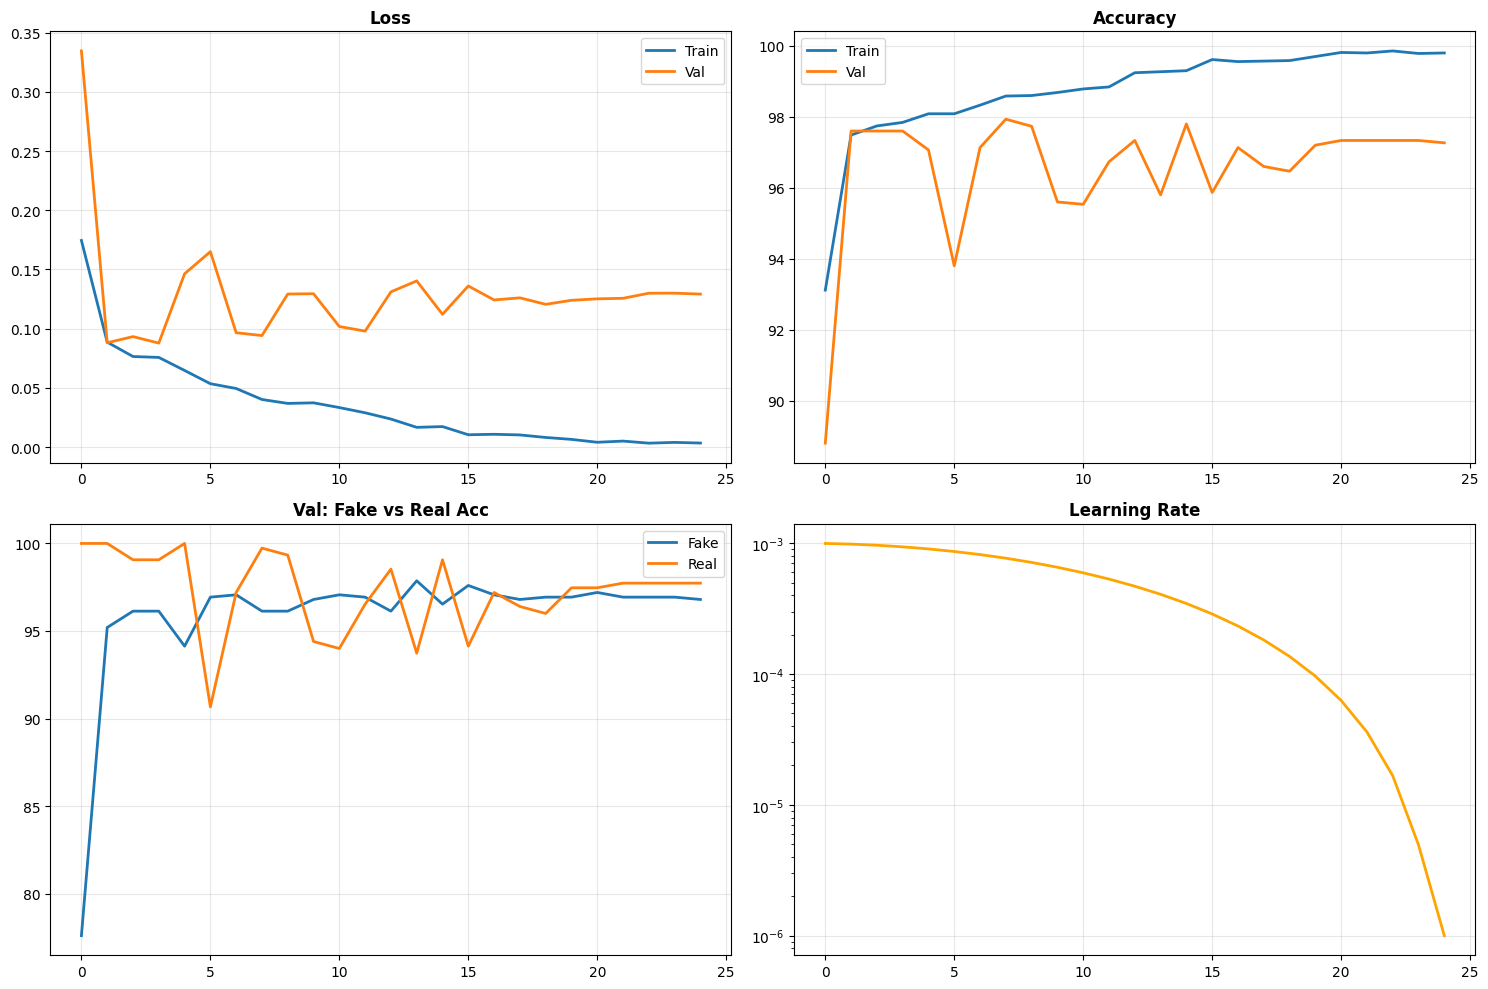

📊 Saved: training_curves.png


In [ ]:
# Plot Training Curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val', linewidth=2)
axes[0, 0].set_title('Loss', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Val', linewidth=2)
axes[0, 1].set_title('Accuracy', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Fake vs Real
axes[1, 0].plot(history['val_fake_acc'], label='Fake', linewidth=2)
axes[1, 0].plot(history['val_real_acc'], label='Real', linewidth=2)
axes[1, 0].set_title('Val: Fake vs Real Acc', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
axes[1, 1].plot(history['learning_rate'], linewidth=2, color='orange')
axes[1, 1].set_title('Learning Rate', fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(run_dir, 'training_curves.png'), dpi=150)
plt.show()

print(f"📊 Saved: training_curves.png")


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import timm
from datetime import datetime
import json


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import kagglehub
path = kagglehub.dataset_download("mbulsss/fakeavceleb-preprocessed-frame")
print(f"\n📁 Dataset path: {path}")

100%|██████████| 2.32G/2.32G [00:13<00:00, 185MB/s]


Extracting files...

📁 Dataset path: /root/.cache/kagglehub/datasets/mbulsss/fakeavceleb-preprocessed-frame/versions/2


In [17]:
import os, torch

class Config:
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    DATA_ROOT = path
    BATCH_SIZE = 128
    NUM_WORKERS = 0
    PIN_MEMORY = True

cfg = Config()

run_dir = "/content/drive/MyDrive/deepfake_checkpoints/xception_20251213_125347"
print("Using run_dir:", run_dir)


Using run_dir: /content/drive/MyDrive/deepfake_checkpoints/xception_20251213_125347


In [18]:
import timm

model = timm.create_model('xception', pretrained=True)
model.reset_classifier(2)
model = model.to(cfg.DEVICE)

ckpt_path = os.path.join(run_dir, "epoch_007.pt")
checkpoint = torch.load(ckpt_path, map_location=cfg.DEVICE, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(cfg.DEVICE)


In [19]:
test_overall_acc, test_fake_acc, test_real_acc = test_model(
    model, test_loader, cfg.DEVICE
)


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


TEST RESULTS
Overall Acc : 97.40%
Fake (0) Acc: 97.47%
Real (1) Acc: 97.33%



🧪 COMPREHENSIVE TESTING

🔍 Running inference on test set...


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


📊 Calculating metrics...

📊 TEST SET RESULTS

---------------------------OVERALL METRICS----------------------------
  Accuracy:               97.40%
  ROC-AUC:                99.29%

-------------------------FAKE CLASS (Class 0)-------------------------
  Precision:              97.34%
  Recall (Sensitivity):   97.47%
  F1-Score:               97.40%
  Accuracy:               97.47%

-------------------------REAL CLASS (Class 1)-------------------------
  Precision:              97.46%
  Recall (Sensitivity):   97.33%
  F1-Score:               97.40%
  Accuracy:               97.33%

---------------------------CONFUSION MATRIX---------------------------

                    Predicted
                 FAKE      REAL
  Actual FAKE     731        19     (97.5% correct)
         REAL      20       730     (97.3% correct)

--------------------------DETAILED BREAKDOWN--------------------------
  True Negatives  (TN):  731  (Correctly identified FAKE)
  False Positives (FP):   19  (FAKE pre

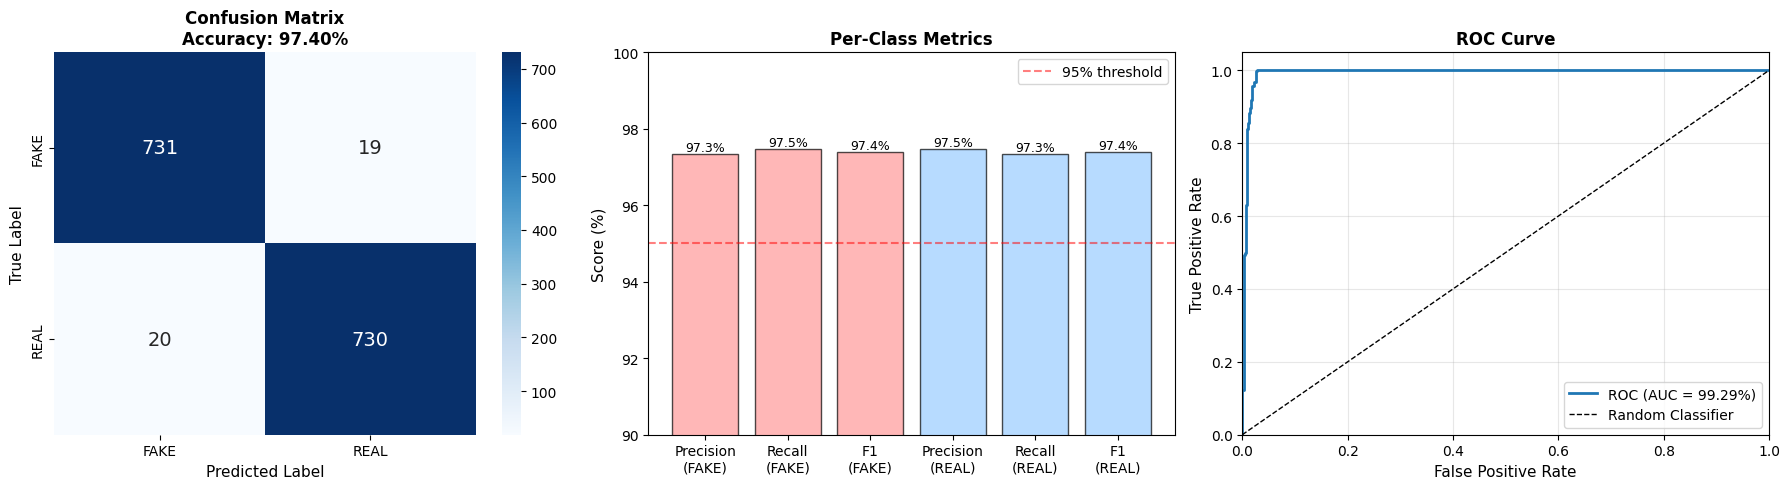


💾 Saved visualization: test_comprehensive_metrics.png
💾 Saved JSON: test_detailed_results.json

📋 SUMMARY TABLE

Metric                    FAKE         REAL         Overall     
----------------------------------------------------------------------
Precision                      97.34%      97.46%           -
Recall (Sensitivity)           97.47%      97.33%           -
F1-Score                       97.40%      97.40%           -
Accuracy                       97.47%      97.33%      97.40%
ROC-AUC                             -           -      99.29%

✅ TESTING COMPLETE!


In [ ]:
# ===========================================
# COMPREHENSIVE TESTING WITH ALL METRICS
# ===========================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    roc_curve
)
import json

print("\n" + "="*70)
print("🧪 COMPREHENSIVE TESTING")
print("="*70)

# ===========================================
# 1. RUN TESTING & COLLECT PREDICTIONS
# ===========================================
model.eval()
all_preds = []
all_labels = []
all_probs = []

print("\n🔍 Running inference on test set...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        images = batch['image'].to(cfg.DEVICE, non_blocking=True)
        labels = batch['label']

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability for REAL class

# Convert to numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# ===========================================
# 2. CALCULATE ALL METRICS
# ===========================================
print("\n📊 Calculating metrics...")

# Overall metrics
accuracy = accuracy_score(all_labels, all_preds) * 100

# Per-class metrics (for REAL class as positive)
precision_real = precision_score(all_labels, all_preds, pos_label=1) * 100
recall_real = recall_score(all_labels, all_preds, pos_label=1) * 100
f1_real = f1_score(all_labels, all_preds, pos_label=1) * 100

# Per-class metrics (for FAKE class as positive)
precision_fake = precision_score(all_labels, all_preds, pos_label=0) * 100
recall_fake = recall_score(all_labels, all_preds, pos_label=0) * 100
f1_fake = f1_score(all_labels, all_preds, pos_label=0) * 100

# ROC AUC
try:
    roc_auc = roc_auc_score(all_labels, all_probs) * 100
except:
    roc_auc = 0.0

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Per-class accuracy
fake_mask = (all_labels == 0)
real_mask = (all_labels == 1)
fake_acc = (all_preds[fake_mask] == 0).mean() * 100
real_acc = (all_preds[real_mask] == 1).mean() * 100

# ===========================================
# 3. PRINT RESULTS
# ===========================================
print("\n" + "="*70)
print("📊 TEST SET RESULTS")
print("="*70)

print(f"\n{'OVERALL METRICS':-^70}")
print(f"  Accuracy:              {accuracy:6.2f}%")
print(f"  ROC-AUC:               {roc_auc:6.2f}%")

print(f"\n{'FAKE CLASS (Class 0)':-^70}")
print(f"  Precision:             {precision_fake:6.2f}%")
print(f"  Recall (Sensitivity):  {recall_fake:6.2f}%")
print(f"  F1-Score:              {f1_fake:6.2f}%")
print(f"  Accuracy:              {fake_acc:6.2f}%")

print(f"\n{'REAL CLASS (Class 1)':-^70}")
print(f"  Precision:             {precision_real:6.2f}%")
print(f"  Recall (Sensitivity):  {recall_real:6.2f}%")
print(f"  F1-Score:              {f1_real:6.2f}%")
print(f"  Accuracy:              {real_acc:6.2f}%")

print(f"\n{'CONFUSION MATRIX':-^70}")
print(f"\n                    Predicted")
print(f"                 FAKE      REAL")
print(f"  Actual FAKE    {cm[0,0]:4d}      {cm[0,1]:4d}     ({cm[0,0]/(cm[0,0]+cm[0,1])*100:.1f}% correct)")
print(f"         REAL    {cm[1,0]:4d}      {cm[1,1]:4d}     ({cm[1,1]/(cm[1,0]+cm[1,1])*100:.1f}% correct)")

print(f"\n{'DETAILED BREAKDOWN':-^70}")
print(f"  True Negatives  (TN): {cm[0,0]:4d}  (Correctly identified FAKE)")
print(f"  False Positives (FP): {cm[0,1]:4d}  (FAKE predicted as REAL)")
print(f"  False Negatives (FN): {cm[1,0]:4d}  (REAL predicted as FAKE)")
print(f"  True Positives  (TP): {cm[1,1]:4d}  (Correctly identified REAL)")

# ===========================================
# 4. SKLEARN CLASSIFICATION REPORT
# ===========================================
print(f"\n{'SKLEARN CLASSIFICATION REPORT':-^70}")
print(classification_report(
    all_labels, all_preds,
    target_names=['FAKE (0)', 'REAL (1)'],
    digits=4
))

# ===========================================
# 5. VISUALIZATIONS
# ===========================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Confusion Matrix ---
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['FAKE', 'REAL'],
            yticklabels=['FAKE', 'REAL'],
            annot_kws={"size": 14},
            ax=axes[0])
axes[0].set_title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}%',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# --- Plot 2: Metrics Bar Chart ---
metrics_names = ['Precision\n(FAKE)', 'Recall\n(FAKE)', 'F1\n(FAKE)',
                 'Precision\n(REAL)', 'Recall\n(REAL)', 'F1\n(REAL)']
metrics_values = [precision_fake, recall_fake, f1_fake,
                  precision_real, recall_real, f1_real]
colors = ['#ff9999', '#ff9999', '#ff9999', '#99ccff', '#99ccff', '#99ccff']

bars = axes[1].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylim([90, 100])
axes[1].set_ylabel('Score (%)', fontsize=11)
axes[1].set_title('Per-Class Metrics', fontsize=12, fontweight='bold')
axes[1].axhline(y=95, color='red', linestyle='--', alpha=0.5, label='95% threshold')
axes[1].legend()

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f}%',
                ha='center', va='bottom', fontsize=9)

# --- Plot 3: ROC Curve ---
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
axes[2].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.2f}%)')
axes[2].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate', fontsize=11)
axes[2].set_ylabel('True Positive Rate', fontsize=11)
axes[2].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[2].legend(loc="lower right")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()

# Save plot
save_path = os.path.join(run_dir, 'test_comprehensive_metrics.png')
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Saved visualization: test_comprehensive_metrics.png")

# ===========================================
# 6. SAVE RESULTS TO JSON
# ===========================================
results = {
    'model_info': {
        'checkpoint': 'best_model.pt',
        'epoch': int(checkpoint['epoch']),
        'validation_acc': float(checkpoint['metrics']['val_acc'])
    },
    'test_metrics': {
        'accuracy': float(accuracy),
        'roc_auc': float(roc_auc),
        'fake_class': {
            'precision': float(precision_fake),
            'recall': float(recall_fake),
            'f1_score': float(f1_fake),
            'accuracy': float(fake_acc)
        },
        'real_class': {
            'precision': float(precision_real),
            'recall': float(recall_real),
            'f1_score': float(f1_real),
            'accuracy': float(real_acc)
        }
    },
    'confusion_matrix': {
        'TN': int(cm[0,0]),
        'FP': int(cm[0,1]),
        'FN': int(cm[1,0]),
        'TP': int(cm[1,1])
    }
}

json_path = os.path.join(run_dir, 'test_detailed_results.json')
with open(json_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"💾 Saved JSON: test_detailed_results.json")

# ===========================================
# 7. SUMMARY TABLE
# ===========================================
print("\n" + "="*70)
print("📋 SUMMARY TABLE")
print("="*70)

print(f"\n{'Metric':<25} {'FAKE':<12} {'REAL':<12} {'Overall':<12}")
print("-" * 70)
print(f"{'Precision':<25} {precision_fake:>10.2f}% {precision_real:>10.2f}% {'-':>11}")
print(f"{'Recall (Sensitivity)':<25} {recall_fake:>10.2f}% {recall_real:>10.2f}% {'-':>11}")
print(f"{'F1-Score':<25} {f1_fake:>10.2f}% {f1_real:>10.2f}% {'-':>11}")
print(f"{'Accuracy':<25} {fake_acc:>10.2f}% {real_acc:>10.2f}% {accuracy:>10.2f}%")
print(f"{'ROC-AUC':<25} {'-':>11} {'-':>11} {roc_auc:>10.2f}%")

print("\n" + "="*70)
print("✅ TESTING COMPLETE!")
print("="*70)

🎬 VIDEO DEEPFAKE DETECTION (HYBRID)

⚙️  Config:
   Frame skip: 5
   Frame REAL threshold: 0.25
   Video REAL ratio threshold: 0.7
   Min face: 80x80

📥 Loading face detectors...
✅ Both detectors loaded!

📤 Upload video:


Saving Download.mp4 to Download (1).mp4
✅ Uploaded: Download (1).mp4

🚀 START

📹 Video Info:
   480x480 @ 29fps
   Duration: 16.6s

🔍 Processing...


  0%|          | 0/480 [00:00<?, ?it/s]


✅ Done!
   Frames checked: 480
   Faces found: 96
   Detection methods: DNN=96, Haar=0

📊 DETAILED ANALYSIS

Frames analyzed: 96
  Mean REAL prob: 0.414
  Median REAL prob: 0.292

Frame Distribution:
  Very Confident FAKE (<0.2):  41 ( 42.7%)
  Confident FAKE (<0.4):       50 ( 52.1%)
  Uncertain (0.4-0.7):          9 (  9.4%)
  Confident REAL (>0.85):      17 ( 17.7%)

------------------------ CLASSIFICATION LOGIC ------------------------

--------------------------- FINAL VERDICT ----------------------------

  🔴 Classification: FAKE
  Confidence Level: HIGH
  Reason: Mean REAL probability < 0.5

  ✅ Action: Video classified as deepfake

------------------------- TECHNICAL DETAILS --------------------------
  Frames with threshold 0.25:
    FAKE:  45 ( 46.9%)
    REAL:  51 ( 53.1%)
  Video-level threshold: 0.7
  Actual REAL ratio: 0.531

--------------------------- SAMPLE FRAMES ----------------------------

Frame 1: FAKE (89.7%) [R=10.3% F=89.7%] via DNN


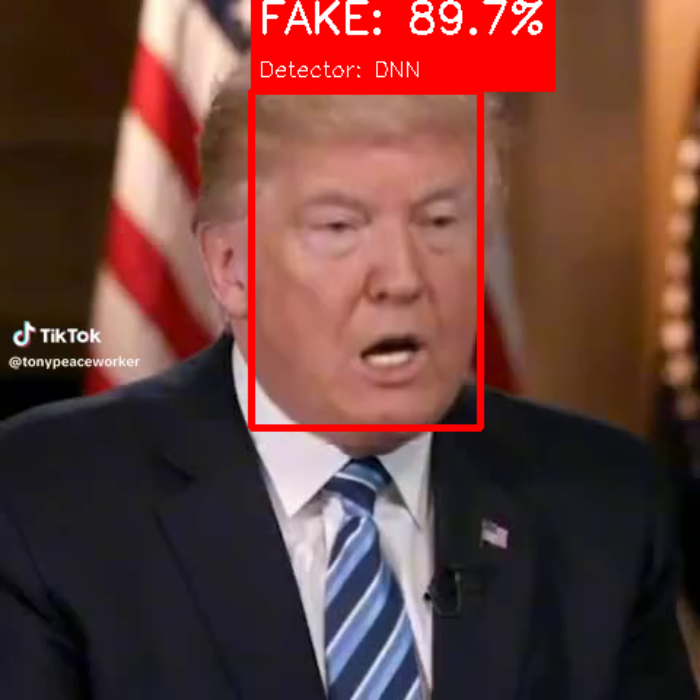


Frame 2: FAKE (99.9%) [R=0.1% F=99.9%] via DNN


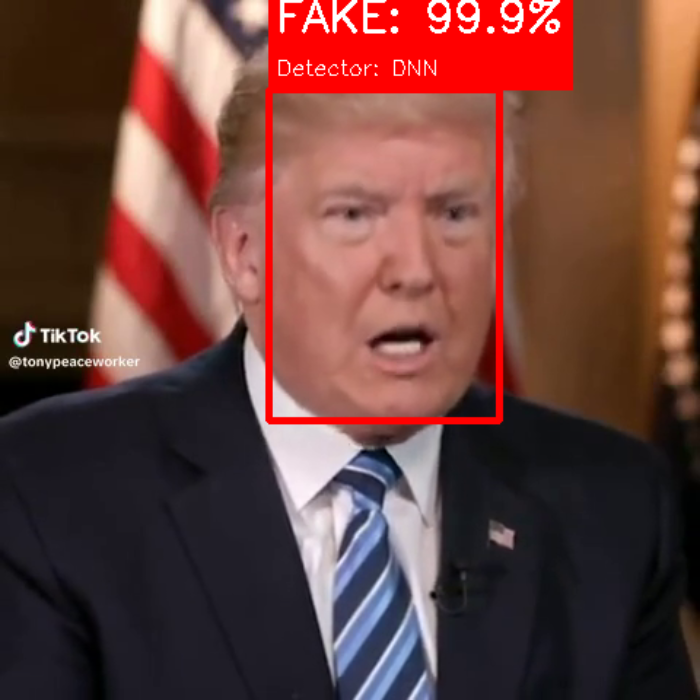


Frame 3: REAL (84.2%) [R=84.2% F=15.8%] via DNN


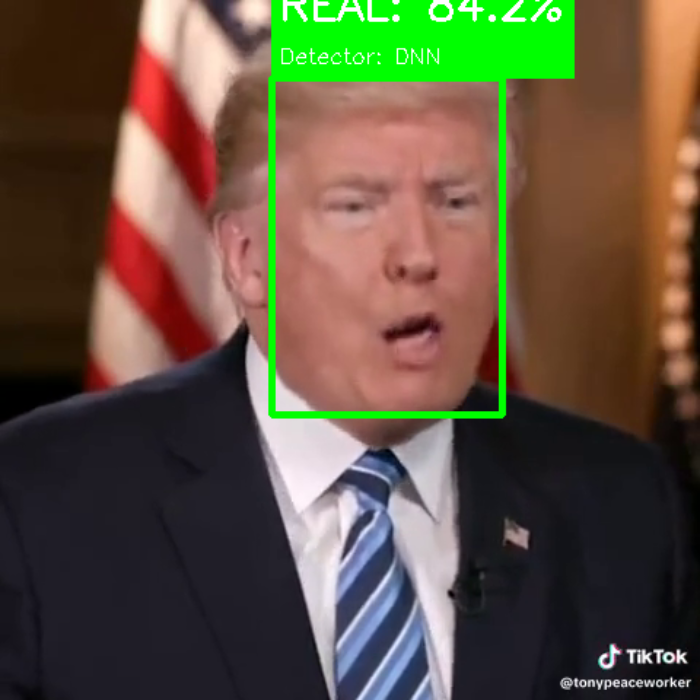


Frame 4: FAKE (99.5%) [R=0.5% F=99.5%] via DNN


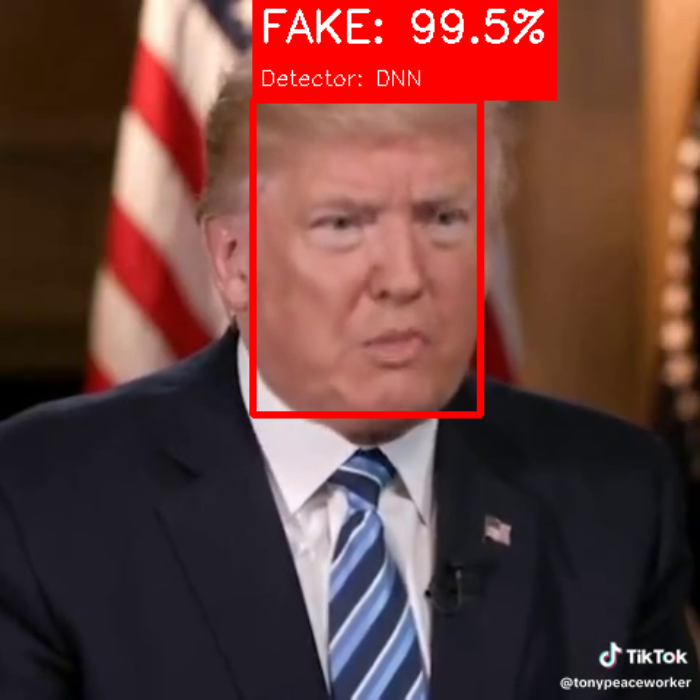


Frame 5: FAKE (99.1%) [R=0.9% F=99.1%] via DNN


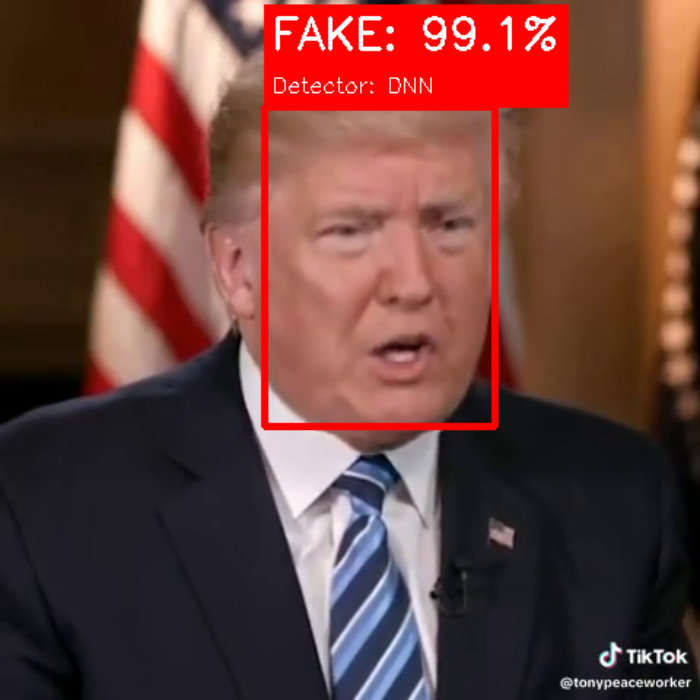


Frame 6: REAL (82.0%) [R=82.0% F=18.0%] via DNN


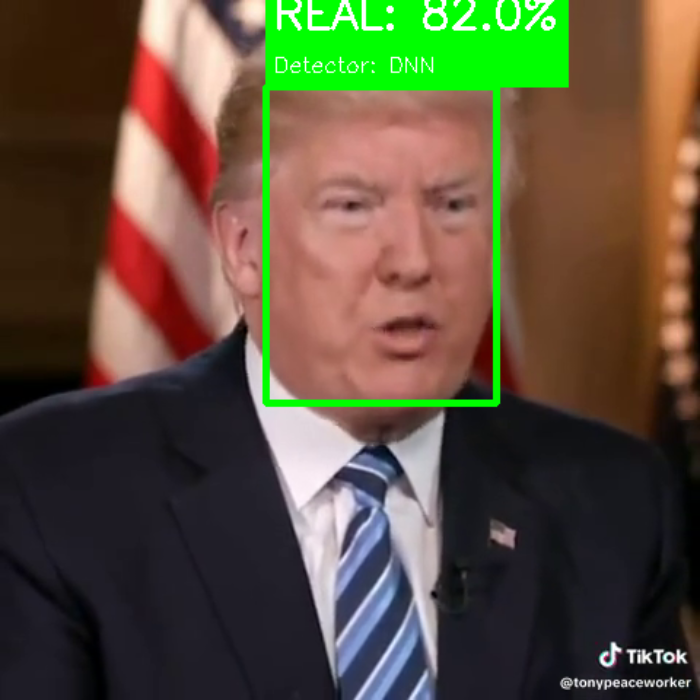

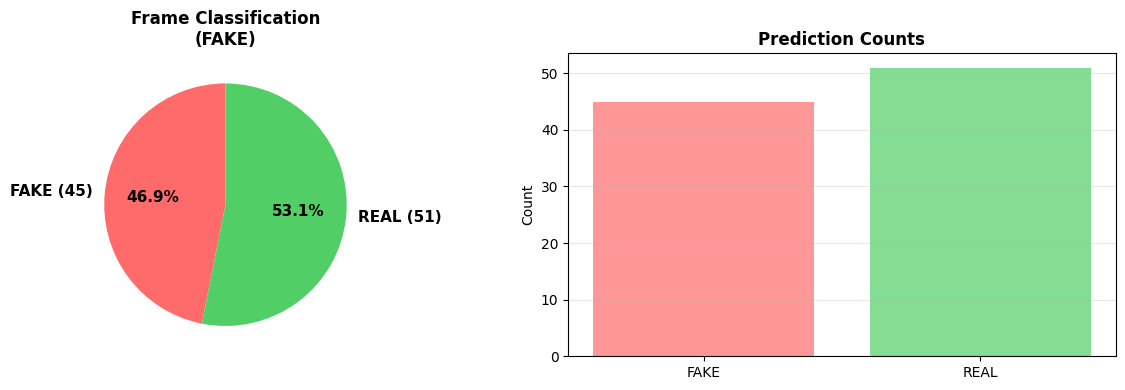


✅ Complete!


In [21]:
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from google.colab.patches import cv2_imshow
from tqdm.auto import tqdm

print("="*70)
print("🎬 VIDEO DEEPFAKE DETECTION (HYBRID)")
print("="*70)

# ===========================================
# CONFIG
# ===========================================
class Config:
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    FRAME_SKIP = 5
    MAX_FRAMES = 500

# ✅ THRESHOLD BARU (berdasarkan analisis)
    # Option 1: OPTIMAL (Youden's J) - Balanced
    CONFIDENCE_THRESHOLD = 0.25  # 0.2453 rounded

    # Option 2: CONSERVATIVE - Lebih aman untuk production
    # CONFIDENCE_THRESHOLD = 0.30  # Best overall accuracy (98.47%)

    # Option 3: BALANCED - Trade-off bagus
    # CONFIDENCE_THRESHOLD = 0.50  # 97.4% acc, balanced recalls

    MIN_FACE_SIZE = 80

    # Video-level threshold (berapa % frames harus REAL)
    # Kalau pakai threshold 0.3, video masih bisa salah klasifikasi
    # Jadi video dianggap REAL hanya jika >70% frames predict REAL
    VIDEO_REAL_RATIO_THRESHOLD = 0.7

cfg = Config()

print(f"\n⚙️  Config:")
print(f"   Frame skip: {cfg.FRAME_SKIP}")
print(f"   Frame REAL threshold: {cfg.CONFIDENCE_THRESHOLD}")
print(f"   Video REAL ratio threshold: {cfg.VIDEO_REAL_RATIO_THRESHOLD}")
print(f"   Min face: {cfg.MIN_FACE_SIZE}x{cfg.MIN_FACE_SIZE}")

# ===========================================
# TRANSFORMS
# ===========================================
test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# ===========================================
# LOAD BOTH DETECTORS
# ===========================================
print("\n📥 Loading face detectors...")

!wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -q https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

dnn_net = cv2.dnn.readNetFromCaffe(
    'deploy.prototxt',
    'res10_300x300_ssd_iter_140000.caffemodel'
)

print("✅ Both detectors loaded!")

# ===========================================
# HYBRID FACE DETECTION
# ===========================================
def detect_face_hybrid(frame, haar_cascade, dnn_net, min_size=80):
    """Try DNN first, fallback to Haar if needed"""
    h, w = frame.shape[:2]

    # METHOD 1: DNN
    blob = cv2.dnn.blobFromImage(
        cv2.resize(frame, (300, 300)), 1.0,
        (300, 300), (104.0, 177.0, 123.0)
    )
    dnn_net.setInput(blob)
    detections = dnn_net.forward()

    best_face = None
    max_conf = 0

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        # threshold DNN: atur 0.3–0.6 sesuai kebutuhan
        if confidence > 0.3:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, x2, y2) = box.astype("int")

            x = max(0, x)
            y = max(0, y)
            x2 = min(w, x2)
            y2 = min(h, y2)

            face_w = x2 - x
            face_h = y2 - y

            if face_w >= min_size and face_h >= min_size:
                if confidence > max_conf:
                    best_face = (x, y, face_w, face_h, 'DNN', confidence)
                    max_conf = confidence

    # METHOD 2: Haar fallback
    if best_face is None:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = haar_cascade.detectMultiScale(
            gray,
            scaleFactor=1.05,
            minNeighbors=3,
            minSize=(min_size, min_size)
        )

        if len(faces) > 0:
            faces = sorted(faces, key=lambda x: x[2]*x[3], reverse=True)
            x, y, w, h = faces[0]
            best_face = (x, y, w, h, 'Haar', 0.9)

    return best_face

# ===========================================
# UPLOAD VIDEO
# ===========================================
print("\n📤 Upload video:")
from google.colab import files
uploaded = files.upload()

video_path = list(uploaded.keys())[0]
print(f"✅ Uploaded: {video_path}")

# ===========================================
# PROCESS VIDEO
# ===========================================
def process_video(video_path, model, haar_cascade, dnn_net, device):
    """Process video with hybrid detection"""

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("❌ Cannot open video!")
        return None

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"\n📹 Video Info:")
    print(f"   {width}x{height} @ {fps}fps")
    print(f"   Duration: {total_frames/fps:.1f}s")

    # Storage
    predictions = []
    confidences = []
    annotated_frames = []
    detection_methods = []
    real_probs = []
    fake_probs = []

    frame_count = 0
    faces_found = 0

    print(f"\n🔍 Processing...")

    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=min(total_frames, cfg.MAX_FRAMES))

        while cap.isOpened() and frame_count < cfg.MAX_FRAMES:
            ret, frame = cap.read()

            if not ret:
                break

            if frame_count % cfg.FRAME_SKIP == 0:

                # Detect face (hybrid)
                face_result = detect_face_hybrid(
                    frame, haar_cascade, dnn_net, cfg.MIN_FACE_SIZE
                )

                if face_result is not None:
                    x, y, w, h, method, det_conf = face_result

                    # Extract face
                    face_img = frame[y:y+h, x:x+w]

                    # Preprocess
                    face_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
                    face_tensor = test_transforms(face_pil).unsqueeze(0).to(device)

                    # Predict
                    output = model(face_tensor)
                    prob = torch.softmax(output, dim=1)

                    fake_prob = prob[0, 0].item()
                    real_prob = prob[0, 1].item()

                    # 1) Pakai threshold baru untuk frame-level
                    prediction = 1 if real_prob >= cfg.CONFIDENCE_THRESHOLD else 0
                    confidence = max(fake_prob, real_prob)

                    predictions.append(prediction)
                    confidences.append(confidence)
                    detection_methods.append(method)
                    real_probs.append(real_prob)
                    fake_probs.append(fake_prob)

                    # Annotate
                    frame_copy = frame.copy()

                    color = (0, 255, 0) if prediction == 1 else (0, 0, 255)
                    label = "REAL" if prediction == 1 else "FAKE"

                    cv2.rectangle(frame_copy, (x, y), (x+w, y+h), color, 4)

                    label_text = f"{label}: {confidence*100:.1f}%"
                    method_text = f"Detector: {method}"

                    (text_w, _), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2)

                    cv2.rectangle(frame_copy, (x, y-70), (x+text_w+10, y), color, -1)

                    cv2.putText(frame_copy, label_text, (x+5, y-40),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)
                    cv2.putText(frame_copy, method_text, (x+5, y-10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

                    annotated_frames.append(frame_copy)
                    faces_found += 1

                pbar.update(cfg.FRAME_SKIP)

            frame_count += 1

        pbar.close()

    cap.release()

    print(f"\n✅ Done!")
    print(f"   Frames checked: {frame_count}")
    print(f"   Faces found: {faces_found}")

    if faces_found > 0:
        dnn_count = detection_methods.count('DNN')
        haar_count = detection_methods.count('Haar')
        print(f"   Detection methods: DNN={dnn_count}, Haar={haar_count}")

    return {
        'predictions': predictions,
        'confidences': confidences,
        'annotated_frames': annotated_frames,
        'methods': detection_methods,
        'real_probs': real_probs,
        'fake_probs': fake_probs
    }

# ===========================================
# RUN
# ===========================================
print("\n" + "="*70)
print("🚀 START")
print("="*70)

# pastikan variabel `model` sudah di-load sebelumnya
results = process_video(video_path, model, haar_cascade, dnn_net, cfg.DEVICE)

# ===========================================
# SMART VERDICT - DENGAN MODEL LIMITATION
# ===========================================

if results and len(results['predictions']) > 0:

    predictions = np.array(results['predictions'])
    real_probs = np.array(results['real_probs'])
    fake_probs = np.array(results['fake_probs'])

    fake_count = (predictions == 0).sum()
    real_count = (predictions == 1).sum()
    real_ratio = real_count / len(predictions)

    # ADVANCED METRICS
    mean_real_prob = real_probs.mean()
    median_real_prob = np.median(real_probs)

    # Confident classifications
    very_confident_fake = (real_probs < 0.2).sum()  # <20% REAL prob
    confident_fake = (real_probs < 0.4).sum()       # <40% REAL prob
    uncertain = ((real_probs >= 0.4) & (real_probs < 0.7)).sum()
    confident_real = (real_probs > 0.85).sum()      # >85% REAL prob

    confident_fake_ratio = confident_fake / len(predictions)

    print("\n" + "="*70)
    print("📊 DETAILED ANALYSIS")
    print("="*70)
    print(f"\nFrames analyzed: {len(predictions)}")
    print(f"  Mean REAL prob: {mean_real_prob:.3f}")
    print(f"  Median REAL prob: {median_real_prob:.3f}")

    print(f"\nFrame Distribution:")
    print(f"  Very Confident FAKE (<0.2): {very_confident_fake:3d} ({very_confident_fake/len(predictions)*100:5.1f}%)")
    print(f"  Confident FAKE (<0.4):      {confident_fake:3d} ({confident_fake/len(predictions)*100:5.1f}%)")
    print(f"  Uncertain (0.4-0.7):        {uncertain:3d} ({uncertain/len(predictions)*100:5.1f}%)")
    print(f"  Confident REAL (>0.85):     {confident_real:3d} ({confident_real/len(predictions)*100:5.1f}%)")

    # =============================================
    # SMART CLASSIFICATION LOGIC
    # =============================================

    print(f"\n{' CLASSIFICATION LOGIC ':-^70}")

    # CASE 1: Clear FAKE (mean <0.5)
    if mean_real_prob < 0.5:
        final_label = "FAKE"
        confidence_level = "HIGH"
        reason = "Mean REAL probability < 0.5"
        color = "🔴"

    # CASE 2: Borderline FAKE (0.5 - 0.6)
    elif mean_real_prob < 0.6:
        final_label = "LIKELY FAKE"
        confidence_level = "MEDIUM"
        reason = "Mean REAL probability in borderline range"
        color = "🟠"

    # CASE 3: SUSPICIOUS - High mean BUT significant FAKE frames
    elif mean_real_prob < 0.75 and confident_fake_ratio > 0.15:
        final_label = "SUSPICIOUS"
        confidence_level = "MEDIUM"
        reason = f"Mean {mean_real_prob:.2f} but {confident_fake_ratio*100:.1f}% frames confident FAKE"
        color = "🟡"

    # CASE 4: High mean BUT some FAKE signals (MODERN DEEPFAKE?)
    elif mean_real_prob >= 0.75 and confident_fake_ratio > 0.10:
        final_label = "SUSPICIOUS - Possible Modern Deepfake"
        confidence_level = "LOW"
        reason = f"High mean ({mean_real_prob:.2f}) but {confident_fake_ratio*100:.1f}% FAKE frames detected"
        color = "🟡"

        print(f"\n⚠️  WARNING: Model trained on 2019-2020 deepfakes only!")
        print(f"   Modern deepfake methods may evade detection.")
        print(f"   Mixed signals detected - manual verification recommended.")

    # CASE 5: Very high mean, few FAKE frames (OUT OF DISTRIBUTION)
    elif mean_real_prob >= 0.75:
        final_label = "REAL or UNKNOWN DEEPFAKE TYPE"
        confidence_level = "VERY LOW"
        reason = f"Mean {mean_real_prob:.2f} - either genuine or unrecognized deepfake"
        color = "⚪"

        print(f"\n⚠️  MODEL LIMITATION DETECTED!")
        print(f"   Model cannot confidently classify this video.")
        print(f"   Possible reasons:")
        print(f"   1. Video is genuinely REAL")
        print(f"   2. Modern deepfake method (post-2020)")
        print(f"   3. High-quality deepfake beyond model capability")
        print(f"   Recommendation: Use additional verification methods")

    # CASE 6: Mid-range uncertain
    else:
        final_label = "UNCERTAIN"
        confidence_level = "LOW"
        reason = "Insufficient confidence for classification"
        color = "🟡"

    # =============================================
    # DISPLAY VERDICT
    # =============================================

    print(f"\n{'='*70}")
    print(f"{' FINAL VERDICT ':-^70}")
    print(f"{'='*70}")
    print(f"\n  {color} Classification: {final_label}")
    print(f"  Confidence Level: {confidence_level}")
    print(f"  Reason: {reason}")

    # Additional context
    if final_label == "FAKE":
        print(f"\n  ✅ Action: Video classified as deepfake")
    elif final_label == "LIKELY FAKE":
        print(f"\n  ⚠️  Action: Probable deepfake - recommend verification")
    elif "SUSPICIOUS" in final_label:
        print(f"\n  ⚠️  Action: Manual review REQUIRED")
        print(f"     Mixed signals indicate possible sophisticated deepfake")
    elif "UNKNOWN" in final_label:
        print(f"\n  ⚠️  Action: Cannot determine - out of model scope")
        print(f"     Use alternative detection methods")
    else:
        print(f"\n  ⚠️  Action: Uncertain - further analysis needed")

    print(f"{'='*70}")

    # Tambahan info untuk debugging
    print(f"\n{' TECHNICAL DETAILS ':-^70}")
    print(f"  Frames with threshold {cfg.CONFIDENCE_THRESHOLD}:")
    print(f"    FAKE: {fake_count:3d} ({fake_count/len(predictions)*100:5.1f}%)")
    print(f"    REAL: {real_count:3d} ({real_count/len(predictions)*100:5.1f}%)")
    print(f"  Video-level threshold: {cfg.VIDEO_REAL_RATIO_THRESHOLD}")
    print(f"  Actual REAL ratio: {real_ratio:.3f}")

    # Display samples (existing code...)
    num_samples = min(6, len(results['annotated_frames']))

    if num_samples > 0:
        indices = np.linspace(0, len(results['annotated_frames'])-1, num_samples, dtype=int)

        print(f"\n{' SAMPLE FRAMES ':-^70}\n")

        for i, idx in enumerate(indices):
            frame = results['annotated_frames'][idx]
            pred = "REAL" if predictions[idx] == 1 else "FAKE"
            conf = results['confidences'][idx] * 100
            method = results['methods'][idx]
            rprob = real_probs[idx] * 100
            fprob = fake_probs[idx] * 100

            print(f"Frame {i+1}: {pred} ({conf:.1f}%) "
                  f"[R={rprob:.1f}% F={fprob:.1f}%] via {method}")

            h, w = frame.shape[:2]
            scale = 700 / w
            new_w = 700
            new_h = int(h * scale)
            display = cv2.resize(frame, (new_w, new_h))

            cv2_imshow(display)
            print()

    # Plot (existing code)
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    colors = ['#ff6b6b', '#51cf66']
    axes[0].pie([fake_count, real_count],
                labels=[f'FAKE ({fake_count})', f'REAL ({real_count})'],
                colors=colors, autopct='%1.1f%%', startangle=90,
                textprops={'fontsize': 11, 'fontweight': 'bold'})
    axes[0].set_title(f'Frame Classification\n({final_label})', fontweight='bold')

    axes[1].bar(['FAKE', 'REAL'], [fake_count, real_count], color=colors, alpha=0.7)
    axes[1].set_ylabel('Count')
    axes[1].set_title('Prediction Counts', fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

else:
    print("\n❌ No faces detected!")

print("\n✅ Complete!")